In [ ]:
%cd /content/drive/My\ Drive/lab7

/content/drive/My Drive/lab7


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import random
from torchvision import models, transforms
import PIL

## Load the pre-trained VGG-16 Model

We will load the VGG-16 model from `torchvision.models` module.

In [ ]:
# load the pretrained VGG-16 model for image classification
model = models.vgg16(pretrained=True)
# don't need to find gradients with respect to the prams of the network
for param in model.parameters():
    param.requires_grad = False
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
def rescale(x):
  low, high = x.min(), x.max()
  x_rescaled = (x - low) / (high - low)
  return x_rescaled

def preprocess(image, size = 224):
  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      transforms.Lambda(lambda x: x[None]),
  ])
  return transform(image)

def deprocess(image):
  transform = transforms.Compose([
      transforms.Lambda(lambda x: x[0]),
      transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
      transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
      transforms.Lambda(rescale),
      transforms.ToPILImage(),
  ])
  return transform(image)

# Neural Style Transfer
In this part we will implement the style transfer technique from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The general idea is to take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is VGG-16 as we used in the previous part but you could use any network.

In [ ]:
# We provide this helper code which takes an image, a model (cnn), and returns a dictionary of
# feature maps, one per layer.
def extract_features(x, cnn):
  """
  Use the CNN to extract features from the input image x.
  
  Inputs:
  - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
    will be fed to the CNN.
  - cnn: A PyTorch model that we will use to extract features.
  
  Returns:
  - features: A dictionary of feature for the input images x extracted using the cnn model.
    features[name] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
    from different layers of the network may have different numbers of channels (C_i) and
    spatial dimensions (H_i, W_i).
  """
  features = {}
  prev_feat = x
  for i, module in enumerate(cnn._modules.values()):
    if type(module) == nn.Sequential and i == 0:
      for layer in module.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        next_feat = layer(prev_feat)
        features[name] = next_feat
        prev_feat = next_feat
  return features

## Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. You'll fill in the functions that compute these weighted terms below.

### A: Content loss

We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [ ]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    loss = torch.sum( content_weight * (content_current - content_original)**2 )
    return loss

### B: Style loss

Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix $G$ which represents the correlations between the values in each channel of the feature map (i.e. the "responses" of the filter responsible for that channel), where $F$ is as above. The Gram matrix is an approximation of the covariance matrix -- it tells us how every channel's values (i.e. that filter's activations) correlate with every other channel's values. If we have $C$ channels, matrix $G$ will be of shape $(C, C)$ to capture these correlations.

We want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(C_\ell, H_\ell, W_\ell)$, we can flatten the height and width dimensions so they're just 1 dimension $M_\ell = H_\ell \times W_\ell$: the new shape of $F^\ell$ is $(C_\ell, M_\ell)$. Then, the Gram matrix has shape $(C_\ell, C_\ell)$ where each element is given by the equation:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

In [ ]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Tensor of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    N, C, H, W = features.size()
    features = features.view(N*C,H*W) #reshape it
    gram_matrix = torch.mm(features, features.t())
    if (normalize):
        gram_matrix /= float(H*W*C)
    return gram_matrix

In [ ]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    loss = 0
    for i,layer in enumerate(style_layers):
        current = gram_matrix(feats[layer])
        loss += (style_weights[i] * torch.sum((current-style_targets[i])**2))
    return loss

### C: Total-variation regularization

It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

In [ ]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    loss = 0
    #do the row one
    loss += torch.sum( ( img[:,:,1:,:] - img[:,:,:-1,:] )**2 ) 
    #on paper do for 2X2 and 3X3 then easy to see
    #do the column one
    loss += torch.sum( ( img[:,:,:,1:] - img[:,:,:,:-1] )**2 )
    #weighting
    loss *= tv_weight
    return loss

## Run Style Transfer

Now we're ready to string it all together (you shouldn't have to modify this function):

In [ ]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
    model.type(dtype)
    # Extract features for the content image
    content_img = preprocess(np.asarray(PIL.Image.open(content_image)), size = image_size).cuda()
    feats = extract_features(content_img, model)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(np.asarray(PIL.Image.open(style_image)), size = style_size).cuda()
    feats = extract_features(style_img, model)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()

    for t in range(200):
        if t < 190:
          img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, model)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

First try out `style_transfer` on the parameter set below. Then use your own images to generate some creative and cool pictures!

* The `content_image` is the filename of content image.
* The `style_image` is the filename of style image.
* The `image_size` is the size of smallest image dimension of the content image (used for content loss and generated image).
* The `style_size` is the size of smallest style image dimension.
* The `content_layer` specifies which layer to use for content loss.
* The `content_weight` gives weighting on content loss in the overall loss function. Increasing the value of this parameter will make the final image look more realistic (closer to the original content).
* `style_layers` specifies a list of which layers to use for style loss. 
* `style_weights` specifies a list of weights to use for each layer in style_layers (each of which will contribute a term to the overall style loss). We generally use higher weights for the earlier style layers because they describe more local/smaller scale features, which are more important to texture than features over larger receptive fields. In general, increasing these weights will make the resulting image look less like the original content and more distorted towards the appearance of the style image.
* `tv_weight` specifies the weighting of total variation regularization in the overall loss function. Increasing this value makes the resulting image look smoother and less jagged, at the cost of lower fidelity to style and content.

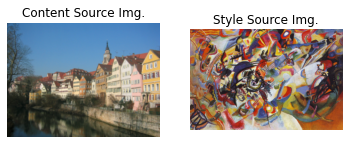

Iteration 0


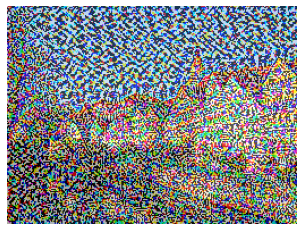

Iteration 100


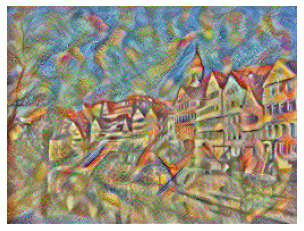

Iteration 199


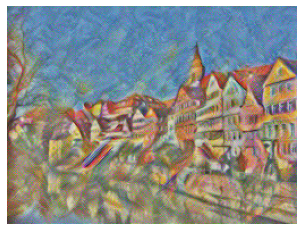

In [ ]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'tubingen.jpg',
    'style_image' : 'composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 'conv_2',
    'content_weight' : 5e-2,
    'style_layers' : ['conv_1', 'conv_3', 'conv_5', 'conv_7'],
    'style_weights' : (20000, 500, 1200, 1000),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

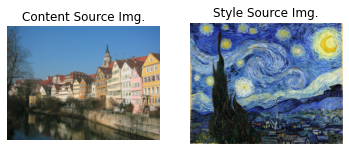

Iteration 0


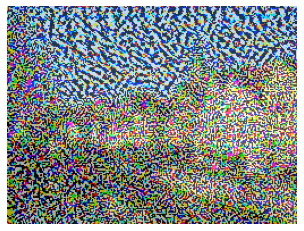

Iteration 100


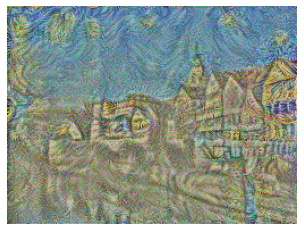

Iteration 199


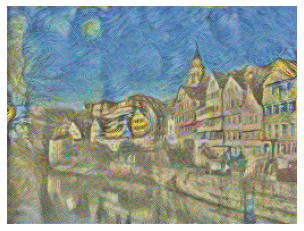

In [ ]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'tubingen.jpg',
    'style_image' : 'starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 'conv_2',
    'content_weight' : 6e-2,
    'style_layers' : ['conv_1', 'conv_4', 'conv_5', 'conv_8'],
    'style_weights' : [3000, 1000, 1500, 300],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

## Feature Inversion (Optional Reading)
The code can do another cool thing. In an attempt to understand the types of features that convolutional networks learn to recognize, a paper "[Understanding Deep Image Representations by Inverting Them](https://arxiv.org/pdf/1412.0035.pdf)" attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network, which is exactly what we did above (but with two different feature representations).

Now, if you set the style weights to all be 0 and initialize the starting image to random noise instead of the content source image, you'll reconstruct an image from the feature representation of the content source image. You're starting with total noise, but you should end up with something that looks quite a bit like your original image.

(Similarly, you could do "texture synthesis" from scratch if you set the content weight to 0 and initialize the starting image to random noise, but we won't ask you to do that here.) 

Run the following cell to try out feature inversion.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting Them", CVPR 2015

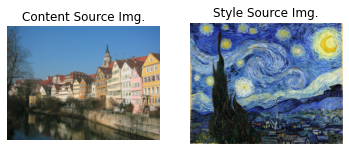

Iteration 0


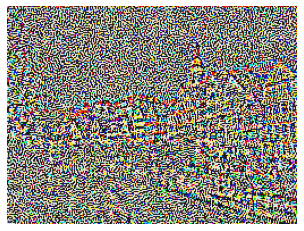

Iteration 100


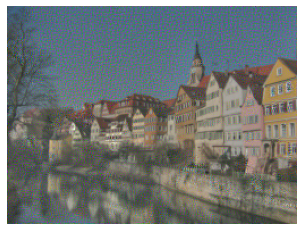

Iteration 199


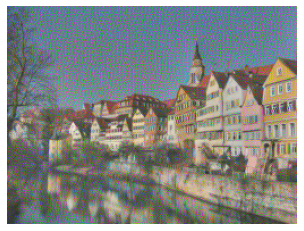

In [ ]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'tubingen.jpg',
    'style_image' : 'starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 'conv_3',
    'content_weight' : 6e-2,
    'style_layers' : ['conv_1', 'conv_4', 'conv_6', 'conv_7'],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)

# Generative Adversarial Networks (GANs)

So far, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variatonal autoencoders combine neural networks with variationl inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Here are some initialization and helper functions for this notebook

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 


Extracting /MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST_data/MNIST/raw




Extracting /MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


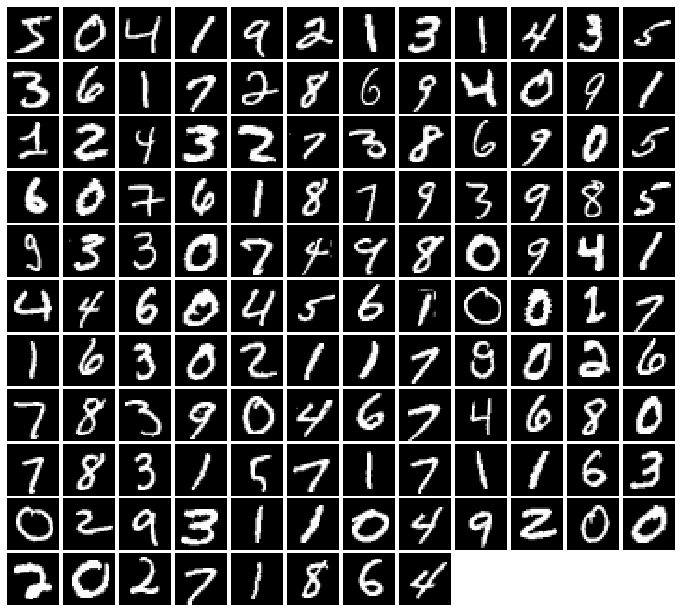

In [ ]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

You can also use `torch.rand`.

Make sure noise is the correct shape and type:

In [ ]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return torch.FloatTensor(batch_size, dim).uniform_(-1, 1)

## Flatten

Here we provide the Flatten and Unflatten method which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

## CPU / GPU
By default all code will run on CPU. GPUs are not needed for this assignment, but will help you to train your models faster. If you do want to run the code on a GPU, then change the `dtype` variable in the following cell.
**If you are a Colab user, it is recommeded to change colab runtime to GPU.**

In [ ]:
dtype = torch.FloatTensor
#dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [ ]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential( Flatten(),
                           nn.Linear(784, 256),
                           nn.LeakyReLU(inplace=True),
                           nn.Linear(256,256),
                           nn.LeakyReLU(inplace=True),
                           nn.Linear(256,1)
                         )
    return model

# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [ ]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential( nn.Linear(noise_dim,1024),
                           nn.ReLU(inplace=True),
                           nn.Linear(1024,1024),
                           nn.ReLU(inplace=True),
                           nn.Linear(1024,784),
                           nn.Tanh()
                         )
    return model

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

Below are implementations of `bce_loss`, `discriminator_loss`, `generator_loss`

In [ ]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [ ]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    N, _ = logits_real.size() 
    loss = (bce_loss(logits_real, torch.ones(N).type(dtype)))+(bce_loss(logits_fake, torch.zeros(N).type(dtype)))
    return loss

In [ ]:
def generator_loss(logits_fake):
    """
    Computes the generator loss described above.
    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    N, _ = logits_fake.size()
    loss = (bce_loss(logits_fake, torch.ones(N).type(dtype)))
    return loss

# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [ ]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr = 1e-3, betas = (0.5,0.999))
    return optimizer

# Training a GAN!

We provide you the main training loop... , but we encourage you to read through and understand it. 

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)
            
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.328, G:0.667


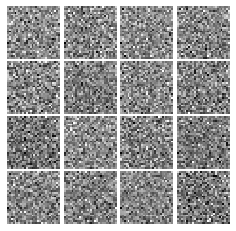


Iter: 250, D: 1.419, G:1.146


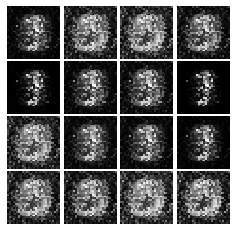


Iter: 500, D: 0.827, G:1.48


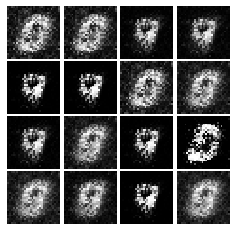


Iter: 750, D: 1.249, G:1.357


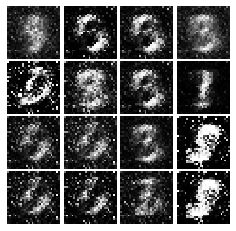


Iter: 1000, D: 1.183, G:0.8594


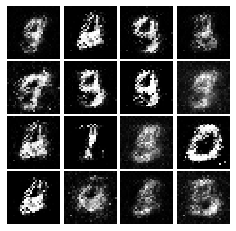


Iter: 1250, D: 1.267, G:1.168


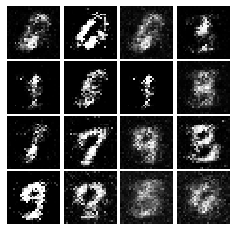


Iter: 1500, D: 1.398, G:0.8665


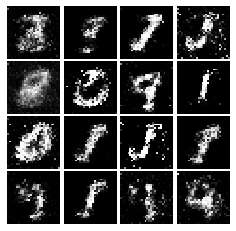


Iter: 1750, D: 1.227, G:0.9822


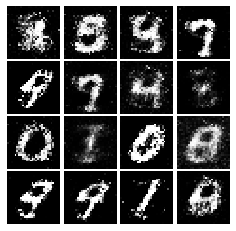


Iter: 2000, D: 1.326, G:0.8801


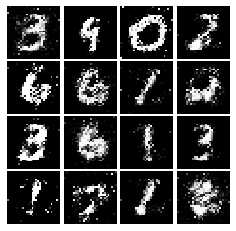


Iter: 2250, D: 1.304, G:0.7561


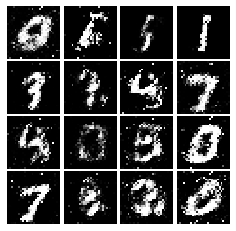


Iter: 2500, D: 1.17, G:0.8545


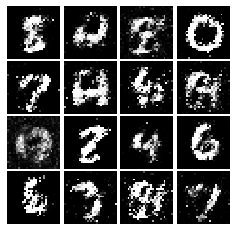


Iter: 2750, D: 1.254, G:0.7961


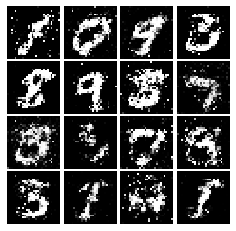


Iter: 3000, D: 1.346, G:0.7553


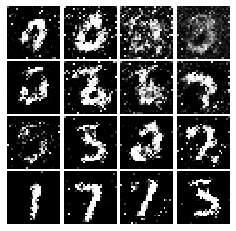


Iter: 3250, D: 1.322, G:0.7878


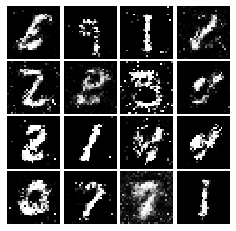


Iter: 3500, D: 1.329, G:0.9118


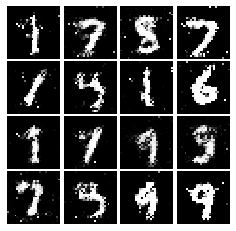


Iter: 3750, D: 1.399, G:0.7548


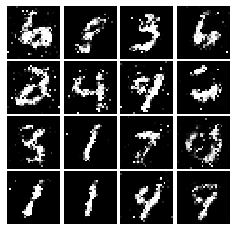

In [ ]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

# Least Squares GAN （Optional Reading）
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

Below are the implementation of `ls_discriminator_loss`, `ls_generator_loss`

In [ ]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    N,_ = scores_real.size()
    loss = (0.5 * torch.mean((scores_real-torch.ones(N).type(dtype))**2)) + (0.5 * torch.mean(scores_fake**2))
    return loss

In [ ]:
def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    N,_ = scores_fake.size()
    loss = (0.5 * torch.mean((scores_fake-torch.ones(N).type(dtype))**2))
    return loss


Run the following cell to train your model!

Iter: 0, D: 0.4884, G:0.4435


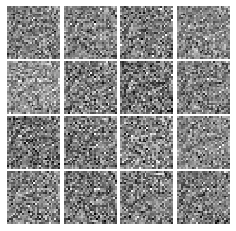


Iter: 250, D: 0.3546, G:0.5698


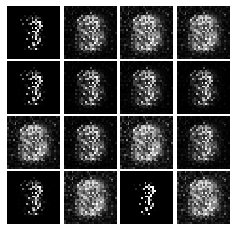


Iter: 500, D: 0.1623, G:0.8017


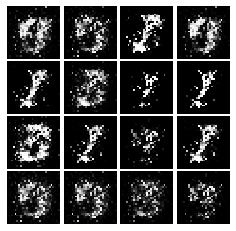


Iter: 750, D: 0.1838, G:0.3001


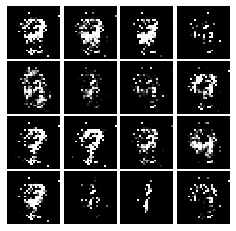


Iter: 1000, D: 0.1111, G:0.3487


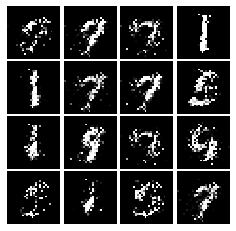


Iter: 1250, D: 0.1989, G:0.2066


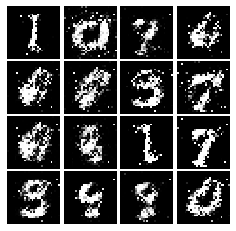


Iter: 1500, D: 0.2062, G:0.2154


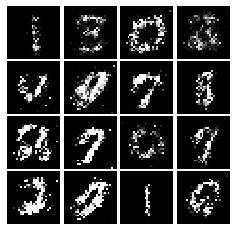


Iter: 1750, D: 0.2283, G:0.1944


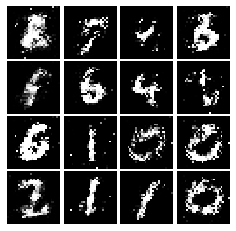


Iter: 2000, D: 0.2383, G:0.1876


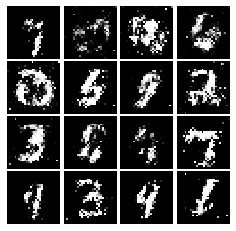


Iter: 2250, D: 0.233, G:0.1688


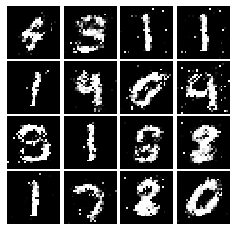


Iter: 2500, D: 0.2315, G:0.1515


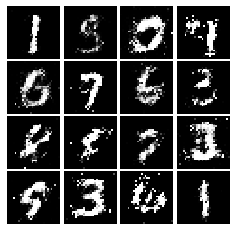


Iter: 2750, D: 0.2045, G:0.1629


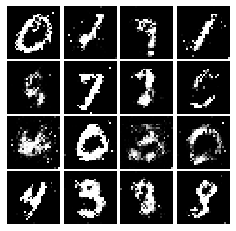


Iter: 3000, D: 0.2066, G:0.1589


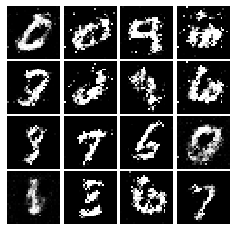


Iter: 3250, D: 0.2162, G:0.1798


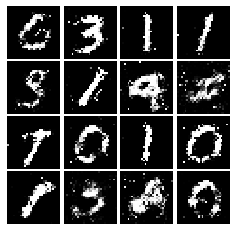


Iter: 3500, D: 0.2374, G:0.1656


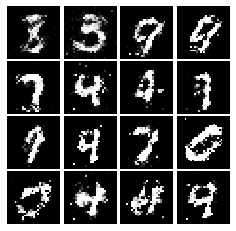


Iter: 3750, D: 0.2459, G:0.1565


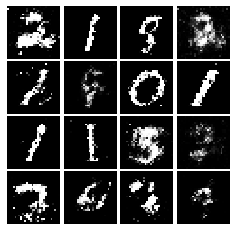

In [ ]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

# Assignment: Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Implement `build_dc_classifier`

In [ ]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

Implement `build_dc_generator`

In [ ]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

In [ ]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)